In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/Desktop/PhD_project/SN_project/SNdata`


In [34]:
include("Likelihood_utils.jl")

plotting_chains (generic function with 1 method)

In [3]:
#    DESI cosmological fiducial value
#    DESI cosmological fiducial value
DESI_h = 0.6736
DESI_Ωb0 = 0.04930
DESI_Ωc0 = 0.26447
DESI_Ωcb0 = DESI_Ωc0 + DESI_Ωb0
DESI_Ωm = 0.3152
DESI_Ωr = 7.981e-05
DESI_Ωk = 0.
DESI_mν = 0.06
DESI_w0 = -1.0
DESI_wa = 0.0
DESI_Neff = 3.046
DESI_Tcmb = 2.7255;

## DESY5

In [4]:
desy5 = DESY5SN_info();

In [5]:
compute_DESY5SNLikelihood(desy5, DESI_Ωcb0, DESI_h, DESI_mν, DESI_w0, DESI_wa, Mb=0.)

-1229.333638240566

In [9]:
desy5_model = DESY5SNLikelihood(desy5.obs_flatdata, desy5)
desy5_mle_estimate = optimize(desy5_model, MLE())

ModeResult with maximized lp of 330.32
[0.48767054731792386, -0.405864018392474, -8.12428944714777, -0.024843486611738186]

In [10]:
print(coeftable(desy5_mle_estimate))

───────────────────────────────────────────────────────────────────────────
         Coef.  Std. Error         z     Pr(>|z|)    Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────
Ωm   0.487671    0.0380371  12.8209   1.25194e-37    0.413119    0.562222
w0  -0.405864    0.319855   -1.2689   0.204477      -1.03277     0.221041
wa  -8.12429     3.94464    -2.05957  0.0394392    -15.8557     -0.392928
Mb  -0.0248435   0.0175682  -1.41412  0.157328      -0.0592765   0.00958957
───────────────────────────────────────────────────────────────────────────

In [11]:
desy5_chain = sample(desy5_model, NUTS(0.65), 1000, init_params=desy5_mle_estimate.values.array)

┌ Info: Found initial step size
└   ϵ = 0.003125
Sampling: 100%|█████████████████████████████████████████| Time: 1:39:18


Chains MCMC chain (1000×16×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 5970.03 seconds
Compute duration  = 5970.03 seconds
parameters        = Ωm, w0, wa, Mb
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

          Ωm    0.4913    0.0368    0.0022   284.2887   386.0578    1.0008     ⋯
          w0   -0.3273    0.3219    0.0235   195.4709   167.3615    0.9998     ⋯
          wa   -9.3096    3.9332    0.2806   201.9137   200.8414    0.9996     ⋯
          Mb   -0.0232    0.0164    0.0010   260.3434   327.2136    1.0073     ⋯
                                                      

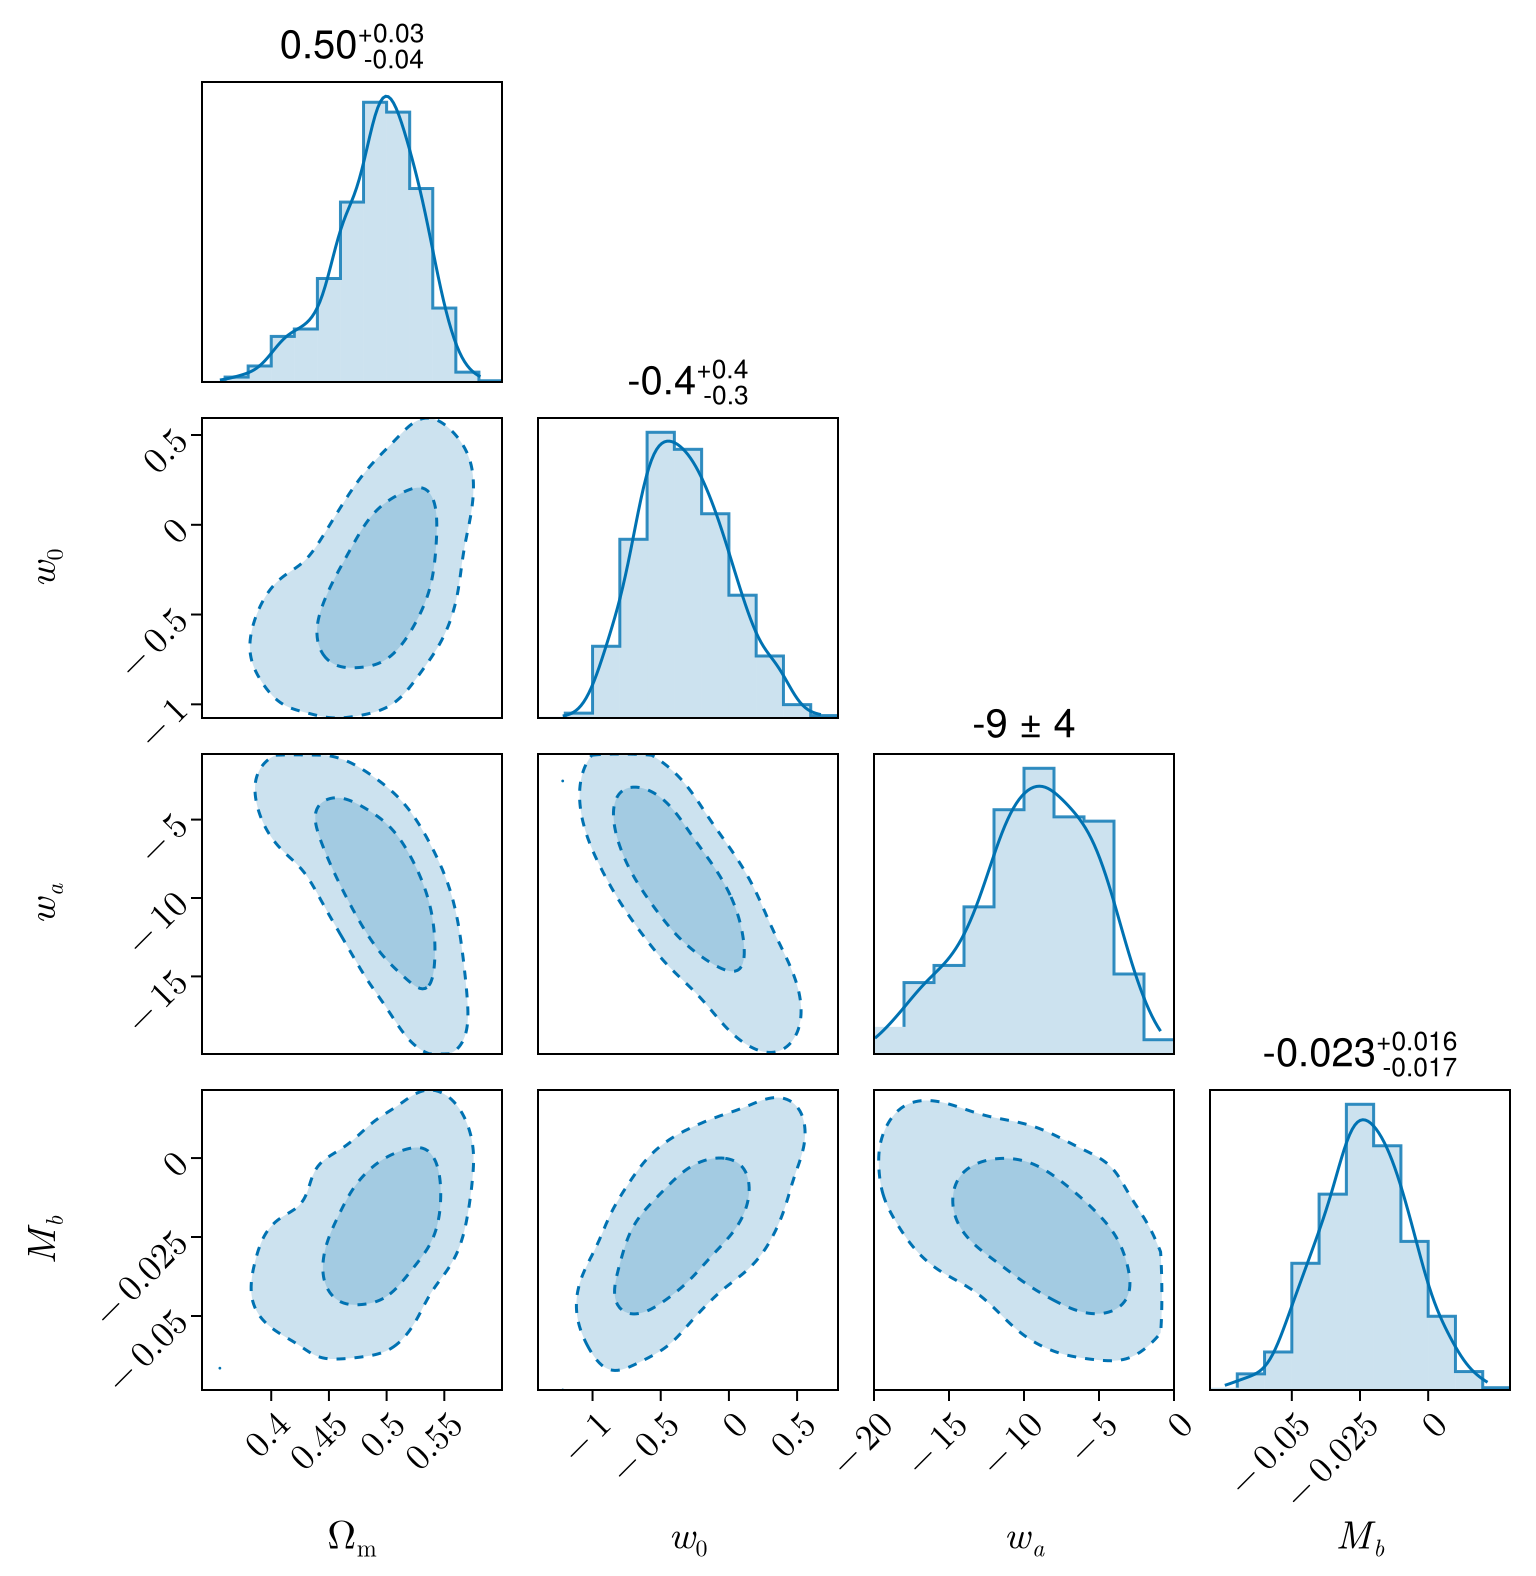

CairoMakie.Screen{IMAGE}


In [35]:
labels = Dict(
        :Ωm => L"\Omega_{\mathrm{m}}",
        :w0 => L"w_{0}",
        :wa => L"w_{a}",
        :Mb => L"M_{b}",
    )
desy5_axis = Dict(
        :Ωm => (;ticks=([0.4, 0.45, 0.5, 0.55], [L"0.4", L"0.45", L"0.5", L"0.55"])),# lims=(low=0.3, high=0.6)),
        :w0 => (;ticks=([-1, -0.5, 0., 0.5], [L"-1", L"-0.5", L"0", L"0.5"])),# lims=(low=-1.25, high=0.75)),
        :wa => (;ticks=([-20, -15., -10, -5, 0], [L"-20", L"-15", L"-10", L"-5", L"0"])),# lims=(low=-20, high=5)),
        :Mb => (;ticks=([-0.05, -0.025, -0.], [L"-0.05", L"-0.025", L"0"])),# lims=(low=-0.075, high=0.025)),
    ) 
plotting_chains(desy5_chain, labels, desy5_axis)

In [85]:
desy5_Mb = mean(desy5_chain[:Mb])
zHD = desy5.data.zHD
function D_L(z)
    return Effort._r_z(z, mean(desy5_chain[:Ωm]), DESI_h; mν=DESI_mν, w0=mean(desy5_chain[:w0]), wa=mean(desy5_chain[:wa]))*(1+z)*DESI_h
end
desy5_flattheory = @. 5 * log10(D_L(zHD) / DESI_h) + 25;

In [91]:
sort_data = sort(DataFrame([zHD desy5_flattheory], :auto), :x1);

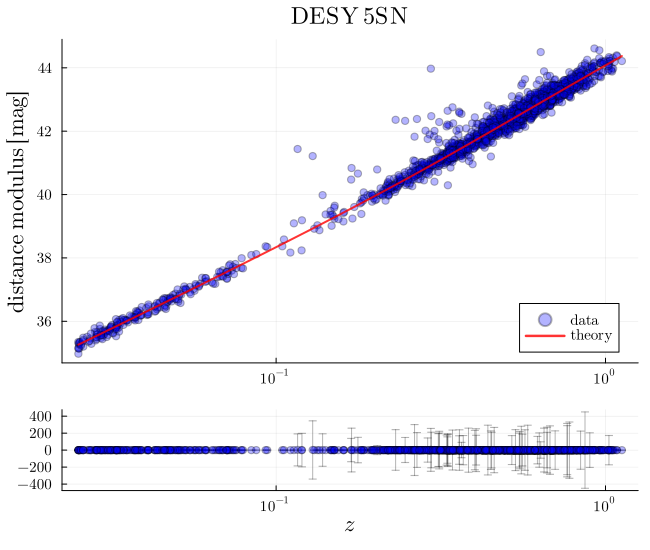

In [120]:
p = Plots.plot(layout=@layout([a;b{0.2h}]), plot_title=L"\mathrm{DESY5SN}", xtickfontsize=10, ytickfontsize=10, xguidefontsize=15, yguidefontsize=15, 
    legend_font_pointsize=10, titlefontsize=20, size=(650,550), xformatter=:latex, yformatter=:latex)

Plots.scatter!(p, zHD, desy5.obs_flatdata .- desy5_Mb, xscale=:log10, alpha=0.3, color="blue", label=L"\mathrm{data}", 
    ylabel=L"\mathrm{distance \; modulus} \; [\mathrm{mag}]", subplot=1)
Plots.plot!(p, sort_data.x1, sort_data.x2, xscale=:log10, alpha=0.8, linewidth=2, color="red", label=L"\mathrm{theory}", subplot=1)

Plots.scatter!(p, zHD, (desy5.obs_flatdata.-desy5_Mb).-desy5_flattheory, yerr=desy5.std, alpha=0.3, color="blue", subplot=2, label="",
xlabel=L"z", xscale=:log10)

## PantheonPlus

In [36]:
pp = PantheonPlusSN_info();

In [37]:
compute_PantheonPlusSNLikelihood(pp, DESI_Ωcb0, DESI_h, DESI_mν, DESI_w0, DESI_wa, Mb=0.)

-1.3335201628817484e7

In [46]:
pp_model = PantheonPlusSNLikelihood(pp.obs_flatdata, pp)
pp_mle_estimate = optimize(pp_model, MLE(), NelderMead())

ModeResult with maximized lp of 846.06
[0.17574570168867637, -0.7975874651569721, 0.5725341188840574, -19.432519845847377]

In [47]:
print(coeftable(pp_mle_estimate))

────────────────────────────────────────────────────────────────────────
         Coef.  Std. Error             z  Pr(>|z|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
Ωm    0.175746    1.15307       0.152416  0.878859   -2.08423    2.43572
w0   -0.797587    1.03795      -0.768423  0.442236   -2.83194    1.23677
wa    0.572534    2.86784       0.19964   0.841762   -5.04832    6.19339
Mb  -19.4325      0.010462  -1857.44      0.0       -19.453    -19.412
────────────────────────────────────────────────────────────────────────

In [48]:
pp_chain = sample(pp_model, NUTS(0.65), 1000, init_params=pp_mle_estimate.values.array)

┌ Info: Found initial step size
└   ϵ = 0.0125
Sampling: 100%|█████████████████████████████████████████| Time: 1:03:20


Chains MCMC chain (1000×16×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 3811.14 seconds
Compute duration  = 3811.14 seconds
parameters        = Ωm, w0, wa, Mb
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters       mean       std      mcse   ess_bulk   ess_tail      rhat    ⋯
      Symbol    Float64   Float64   Float64    Float64    Float64   Float64    ⋯

          Ωm     0.3315    0.1168    0.0081   166.7226   193.4309    1.0098    ⋯
          w0    -0.9060    0.1657    0.0108   236.9177   292.2313    1.0018    ⋯
          wa    -1.3479    2.5546    0.2331   147.7841   144.1227    1.0089    ⋯
          Mb   -19.4287    0.0110    0.0008   179.0007   261.7629    1.0024    ⋯
                                                      

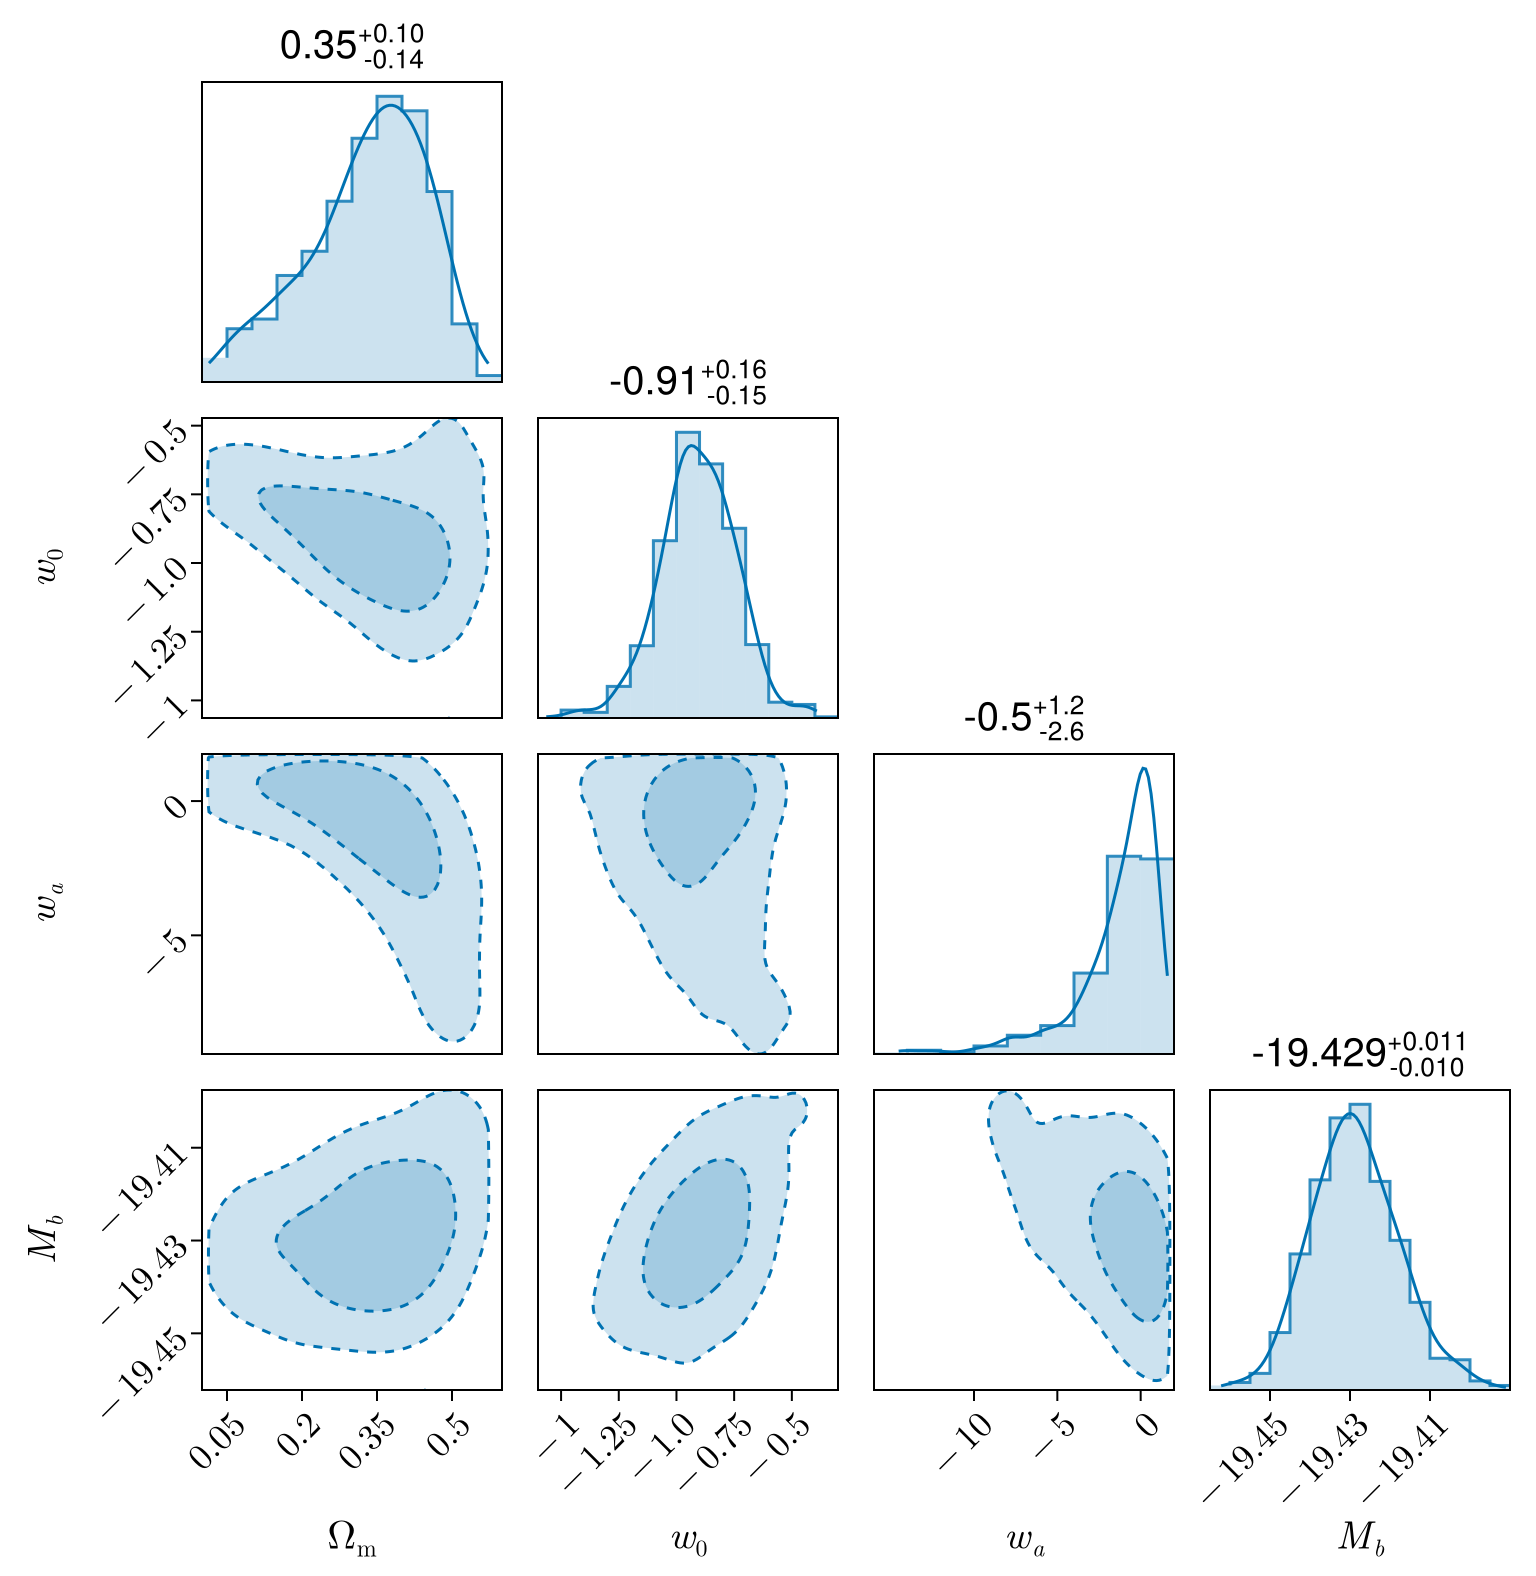

CairoMakie.Screen{IMAGE}


In [49]:
pp_axis = Dict(
            :Ωm => (;ticks=([0.05, 0.2, 0.35, 0.5], [L"0.05", L"0.2", L"0.35", L"0.5"])),# lims=(low=0.3, high=0.6)),
            :w0 => (;ticks=([-1.5, -1.25, -1.0, -0.75, -0.5], [L"-1", L"-1.25", L"-1.0", L"-0.75", L"-0.5"])),# lims=(low=-1.25, high=0.75)),
            :wa => (;ticks=([-10, -5, 0], [L"-10", L"-5", L"0"])),# lims=(low=-20, high=5)),
            :Mb => (;ticks=([-19.45, -19.43, -19.41], [L"-19.45", L"-19.43", L"-19.41"])),# lims=(low=-0.075, high=0.025)),
        )
plotting_chains(pp_chain, labels, pp_axis)

In [123]:
pp_Mb = mean(pp_chain[:Mb])
zHD = pp.data.zHD
function D_L(z)
    return Effort._r_z(z, mean(pp_chain[:Ωm]), DESI_h; mν=DESI_mν, w0=mean(pp_chain[:w0]), wa=mean(pp_chain[:wa]))*(1+z)*DESI_h
end
pp_flattheory = @. 5 * log10(D_L(zHD) / DESI_h) + 25;

In [124]:
sort_data = sort(DataFrame([zHD pp_flattheory], :auto), :x1);

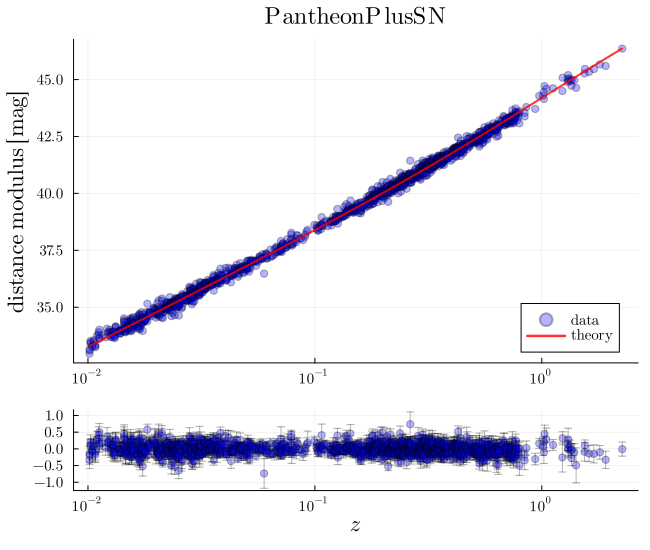

In [125]:
p = Plots.plot(layout=@layout([a;b{0.2h}]), plot_title=L"\mathrm{PantheonPlusSN}", xtickfontsize=10, ytickfontsize=10, xguidefontsize=15, yguidefontsize=15, 
    legend_font_pointsize=10, titlefontsize=20, size=(650,550), xformatter=:latex, yformatter=:latex)

Plots.scatter!(p, zHD, pp.obs_flatdata .- pp_Mb, xscale=:log10, alpha=0.3, color="blue", label=L"\mathrm{data}", 
    ylabel=L"\mathrm{distance \; modulus} \; [\mathrm{mag}]", subplot=1)
Plots.plot!(p, sort_data.x1, sort_data.x2, xscale=:log10, alpha=0.8, linewidth=2, color="red", label=L"\mathrm{theory}", subplot=1)

Plots.scatter!(p, zHD, (pp.obs_flatdata.-pp_Mb).-pp_flattheory, yerr=pp.std, alpha=0.3, color="blue", subplot=2, label="",
xlabel=L"z", xscale=:log10)

## Union3

In [50]:
un3 = Union3SN_info();

In [51]:
compute_Union3SNLikelihood(un3, DESI_Ωcb0, DESI_h, DESI_mν, DESI_w0, DESI_wa, dM=0.)

-5533.764516544355

In [54]:
un3_model = Union3SNLikelihood(un3.obs_flatdata, un3)
un3_mle_estimate = optimize(un3_model, MLE(), NelderMead())

ModeResult with maximized lp of 44.09
[0.4248701655628319, -0.5845143498642869, -3.6168952198697575, -9.258648163457568]

In [55]:
print(coeftable(un3_mle_estimate))

──────────────────────────────────────────────────────────────────────────
        Coef.  Std. Error           z    Pr(>|z|)   Lower 95%    Upper 95%
──────────────────────────────────────────────────────────────────────────
Ωm   0.42487    0.0852706     4.98261  6.27314e-7    0.257743   0.591997
w0  -0.584514   0.295947     -1.97506  0.048261     -1.16456   -0.00446842
wa  -3.6169     3.46506      -1.04382  0.296569    -10.4083     3.1745
dM  -9.25865    0.0915516  -101.13     0.0          -9.43809   -9.07921
──────────────────────────────────────────────────────────────────────────

In [56]:
un3_chain = sample(un3_model, NUTS(0.65), 1000, init_params=un3_mle_estimate.values.array)

┌ Info: Found initial step size
└   ϵ = 0.0125
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04


Chains MCMC chain (1000×16×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 6.04 seconds
Compute duration  = 6.04 seconds
parameters        = Ωm, w0, wa, dM
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

          Ωm    0.4558    0.0669    0.0129    32.2320    20.6947    1.0847     ⋯
          w0   -0.3997    0.3686    0.0349   131.1184    94.6993    1.0075     ⋯
          wa   -6.0432    3.8542    0.4642    46.9037    47.5893    1.0444     ⋯
          dM   -9.2380    0.0930    0.0077   156.8519   138.2387    1.0081     ⋯
                                                            

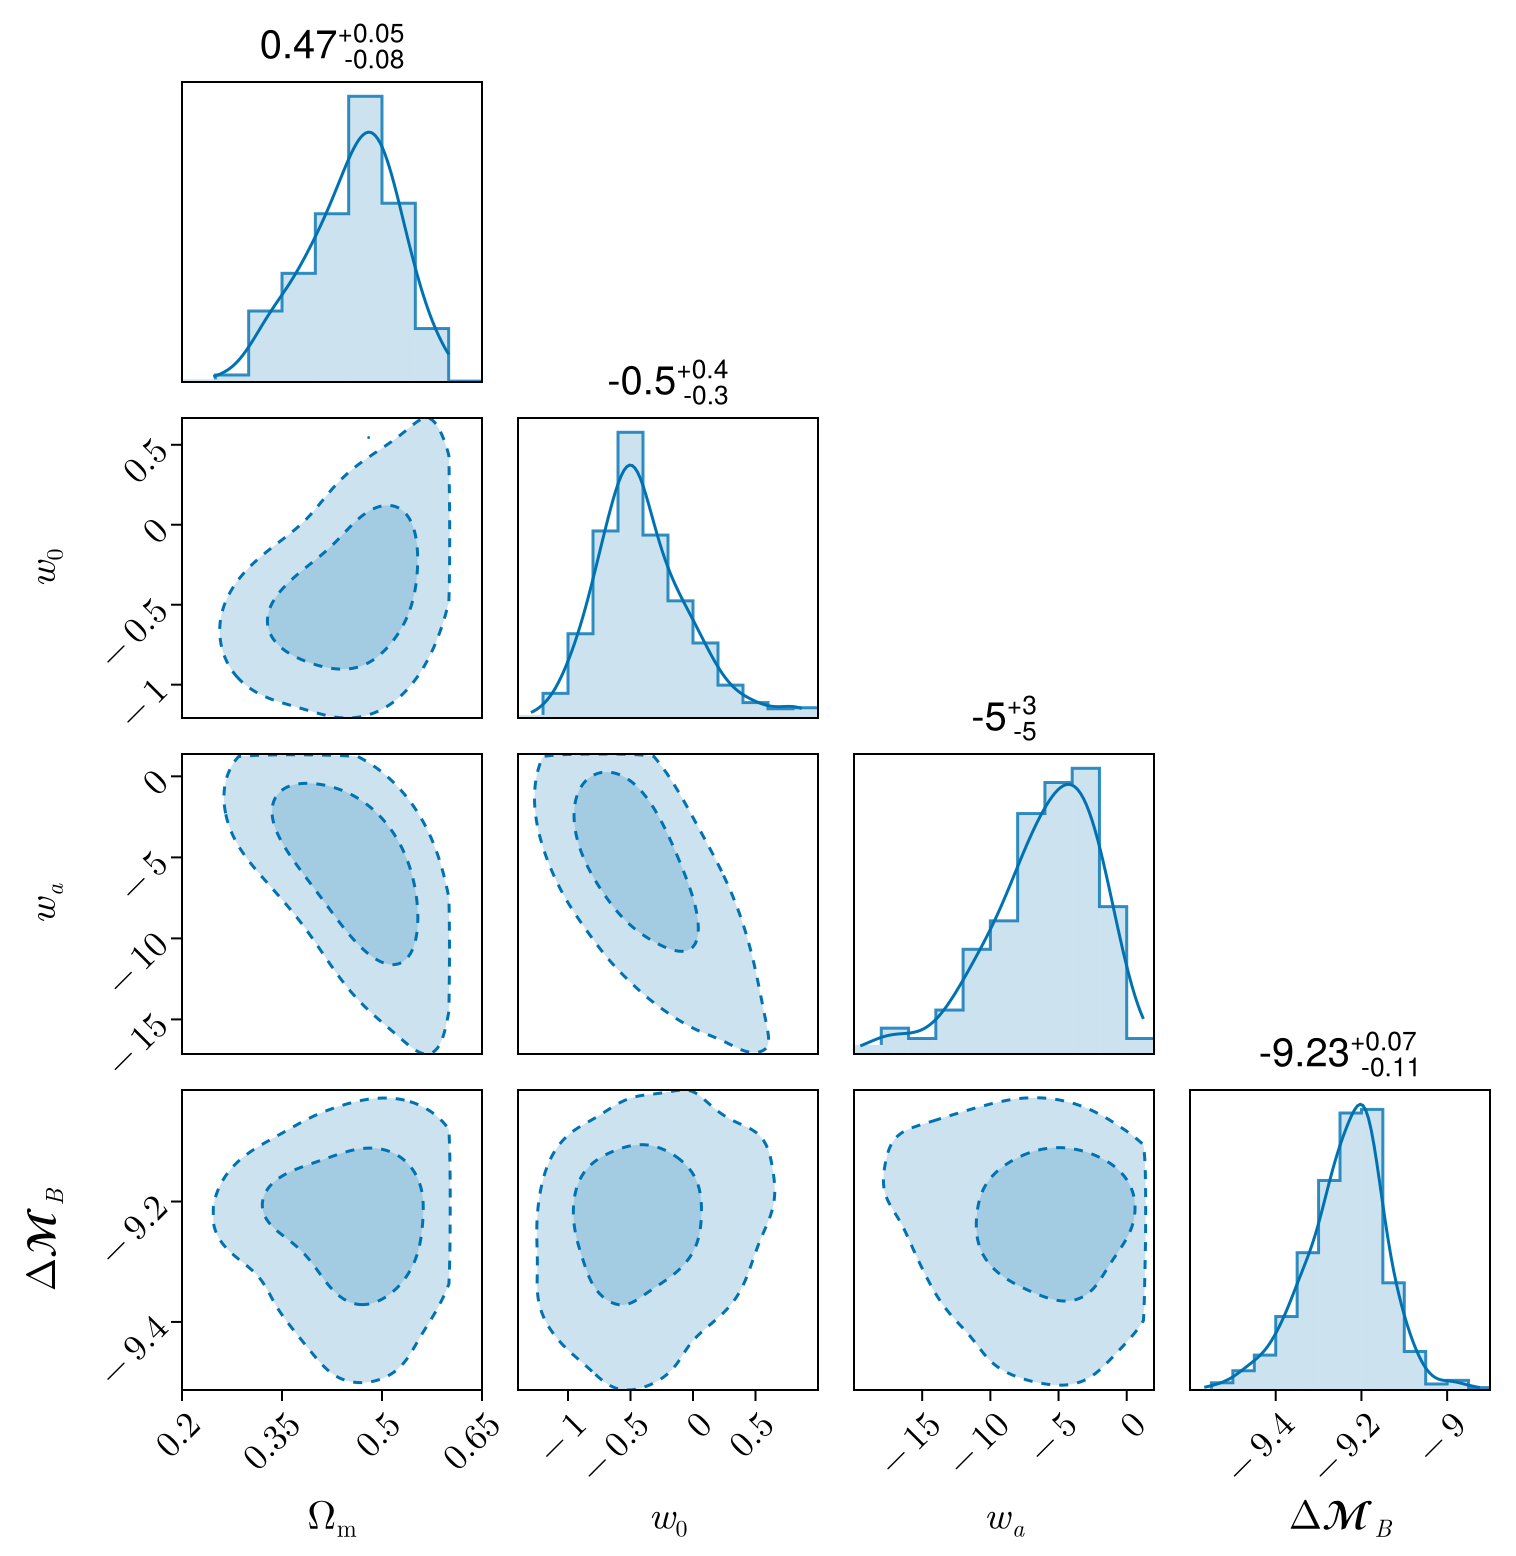

CairoMakie.Screen{IMAGE}


In [71]:
labels = Dict(
        :Ωm => L"\Omega_{\mathrm{m}}",
        :w0 => L"w_{0}",
        :wa => L"w_{a}",
        :dM => L"\Delta\mathcal{M}_B",
    )
un3_axis = Dict(
            :Ωm => (;ticks=([0.05, 0.2, 0.35, 0.5, 0.65], [L"0.05", L"0.2", L"0.35", L"0.5", L"0.65"])),# lims=(low=0.3, high=0.6)),
            :w0 => (;ticks=([-1, -0.5, 0, 0.5], [L"-1", L"-0.5", L"0", L"0.5"])),# lims=(low=-1.25, high=0.75)),
            :wa => (;ticks=([-15, -10, -5, 0], [L"-15", L"-10", L"-5", L"0"])),# lims=(low=-20, high=5)),
            :dM => (;ticks=([-9.4, -9.2, -9], [L"-9.4", L"-9.2", L"-9"])),# lims=(low=-0.075, high=0.025)),
        )
plotting_chains(un3_chain, labels, un3_axis)

In [130]:
un3_dM = mean(un3_chain[:dM])
zcmb = un3.data.zcmb
function D_L(z)
    return Effort._r_z(z, mean(un3_chain[:Ωm]), DESI_h; mν=DESI_mν, w0=mean(un3_chain[:w0]), wa=mean(un3_chain[:wa]))*(1+z)*DESI_h
end
un3_flattheory = @. 5 * log10(100*D_L(zcmb)) + 25;

In [131]:
sort_data = sort(DataFrame([zcmb un3_flattheory], :auto), :x1);

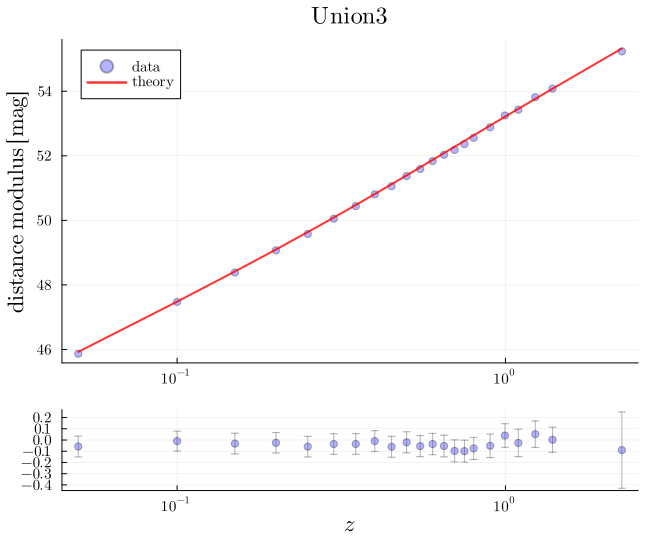

In [132]:
p = Plots.plot(layout=@layout([a;b{0.2h}]), plot_title=L"\mathrm{Union3}", xtickfontsize=10, ytickfontsize=10, xguidefontsize=15, yguidefontsize=15, 
    legend_font_pointsize=10, titlefontsize=20, size=(650,550), xformatter=:latex, yformatter=:latex)

Plots.scatter!(p, zcmb, un3.obs_flatdata .- un3_dM, xscale=:log10, alpha=0.3, color="blue", label=L"\mathrm{data}", 
    ylabel=L"\mathrm{distance \; modulus} \; [\mathrm{mag}]", subplot=1)
Plots.plot!(p, sort_data.x1, sort_data.x2, xscale=:log10, alpha=0.8, linewidth=2, color="red", label=L"\mathrm{theory}", subplot=1)

Plots.scatter!(p, zcmb, (un3.obs_flatdata.-un3_dM).-un3_flattheory, yerr=un3.std, alpha=0.3, color="blue", subplot=2, label="",
xlabel=L"z", xscale=:log10)